# End-to-End Multimodal RAG System

**Authors:** Bayu Ardiyansyah | **Date:** Nov 2025 | **Course:** Image Retrival Final Project

### **Abstract**

Notebook ini mengimplementasikan sistem *Multimodal Retrieval Augmented Generation* (RAG) secara *end-to-end*. Sistem menggabungkan **CLIP (Contrastive Language-Image Pretraining)** untuk ekstraksi fitur semantik, **FAISS** untuk pencarian vektor berkecepatan tinggi, **BLIP-2** untuk *image captioning* otomatis, dan **Llama-3** (via Ollama) untuk penalaran kontekstual. Arsitektur ini dirancang untuk menyelesaikan masalah "kebutaan visual" pada LLM tradisional.

### **0. Setup Lingkungan & Konfigurasi Global**

Inisialisasi pustaka *Deep Learning* (PyTorch, Transformers), manajemen memori GPU, dan konfigurasi *path* dataset sesuai struktur direktori proyek.

In [1]:
# @title 1. Configuration & Enhanced Encoder (FIXED PATHS & FULL CONFIG)
import os
import torch
import numpy as np
from typing import List, Union
from PIL import Image
from transformers import CLIPProcessor, CLIPModel
import pandas as pd
from tqdm import tqdm
import faiss
from typing import List, Tuple

class Config:
    # --- 1. PATH SETTINGS (Sesuai input Anda) ---
    # Mengambil root directory satu level di atas folder notebook saat ini
    PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
    print(f"📍 Project Root: {PROJECT_ROOT}")

    BASE_DIR = PROJECT_ROOT
    # Path Relative (Naik satu level dari notebook)
    IMAGES_DIR = "../Dataset/Images"
    CAPTIONS_FILE = "../Dataset/captions.txt"
    
    # File Index (Disimpan di folder notebook)
    INDEX_PATH = "flickr30k_large.index"      
    METADATA_PATH = "metadata_large.json"
    
    # --- 2. SYSTEM SETTINGS ---
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    TOP_K = 5
    BATCH_SIZE = 16 # Batch kecil karena pakai ViT-Large
    
    # --- 3. RETRIEVAL MODEL (Mata 1) ---
    # Menggunakan ViT-Large sesuai keinginan Anda
    RETRIEVAL_MODEL = "openai/clip-vit-large-patch14" 
    
    # --- 4. GENERATIVE CONFIG (WAJIB ADA UNTUK RAG) ---
    # Bagian ini ditambahkan agar tidak error 'AttributeError' di tahap Generative nanti
    CAPTION_MODEL = "Salesforce/blip2-opt-2.7b"       # Untuk BLIP-2
    LLM_API = "http://localhost:11434/api/generate"   # Untuk Ollama
    LLM_MODEL = "llama3"                              # Untuk Llama 3

class VisualEncoder:
    def __init__(self, model_name: str, device: str):
        self.device = device
        print(f"--> Initializing High-Performance Model: {model_name}")
        self.processor = CLIPProcessor.from_pretrained(model_name)
        self.model = CLIPModel.from_pretrained(model_name).to(device)
        self.model.eval()
        
    def embed_images(self, image_paths: List[str]) -> np.ndarray:
        images = []
        valid_indices = []
        for idx, p in enumerate(image_paths):
            try:
                # Convert ke absolute path agar aman
                full_path = os.path.abspath(p) if not os.path.isabs(p) else p
                img = Image.open(full_path).convert("RGB") 
                images.append(img)
                valid_indices.append(idx)
            except Exception as e: 
                continue
            
        if not images: return np.empty((0, 768)) # ViT-Large dim = 768
        
        inputs = self.processor(images=images, return_tensors="pt", padding=True).to(self.device)
        with torch.no_grad():
            features = self.model.get_image_features(**inputs)
            features = features / features.norm(p=2, dim=-1, keepdim=True) 
        return features.cpu().numpy()

    def embed_text(self, text: Union[str, List[str]]) -> np.ndarray:
        if isinstance(text, str): text = [text]
        text_with_prompt = [f"A photo of {t}" for t in text]
        
        inputs = self.processor(text=text_with_prompt, return_tensors="pt", padding=True, truncation=True, max_length=77).to(self.device)
        with torch.no_grad():
            features = self.model.get_text_features(**inputs)
            features = features / features.norm(p=2, dim=-1, keepdim=True)
        return features.cpu().numpy()

# Re-init Encoder
encoder = VisualEncoder(Config.RETRIEVAL_MODEL, Config.DEVICE)

print("-" * 40)
print(f"🟢 System Runtime: {Config.DEVICE.upper()}")
print(f"🟢 Images Path: {os.path.abspath(Config.IMAGES_DIR)}")
print(f"🟢 Config Loaded: Retrieval={Config.RETRIEVAL_MODEL}, Gen={Config.CAPTION_MODEL}")

2025-11-19 07:09:40.502410: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-19 07:09:40.513735: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763510980.528271    5134 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763510980.532226    5134 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1763510980.545465    5134 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

📍 Project Root: /mnt/d/PROJECT/Knowledge-Infused-Multimodal-Retrieval-A-RAG-Based-Approach-for-Context-Aware-Image-Understanding
--> Initializing High-Performance Model: openai/clip-vit-large-patch14
----------------------------------------
🟢 System Runtime: CUDA
🟢 Images Path: /mnt/d/PROJECT/Knowledge-Infused-Multimodal-Retrieval-A-RAG-Based-Approach-for-Context-Aware-Image-Understanding/Dataset/Images
🟢 Config Loaded: Retrieval=openai/clip-vit-large-patch14, Gen=Salesforce/blip2-opt-2.7b


### **Komponen 1: Dataset (Data Ingestion & Cleaning)**

**Sesuai Penugasan Poin 1:** *Dataset (Flickr30k/Dataset Publik)*.

**Deskripsi:**
Modul ini menangani pemuatan metadata `captions.txt`, pembersihan nama kolom, dan verifikasi integritas fisik file gambar di disk untuk mencegah *runtime error* saat *embedding*.

In [4]:
# @title Komponen 1: Dataset Loading & Integrity Check
class DatasetManager:
    """
    Bertanggung jawab untuk memuat data mentah dan memvalidasi keberadaan aset fisik.
    """ 
    def __init__(self, csv_path: str, img_dir: str):
        self.csv_path = csv_path
        self.img_dir = img_dir
        
    def load_and_verify(self) -> pd.DataFrame:
        print("--> Loading dataset metadata...")
        # Membaca CSV dengan separator koma, menangani potensi error parsing
        df = pd.read_csv(self.csv_path, on_bad_lines='skip')
        
        # Normalisasi nama kolom (menghapus spasi berlebih)
        df.columns = [c.strip() for c in df.columns]
        
        # Deduplikasi: Kita hanya butuh daftar file unik untuk di-embed
        unique_files = df['image'].drop_duplicates().tolist()
        
        valid_files = []
        print(f"--> Verifying {len(unique_files)} unique images on disk...")
        
        for img in tqdm(unique_files):
            if os.path.exists(os.path.join(self.img_dir, img)):
                valid_files.append(img)
            else:
                # Log gambar yang hilang (opsional)
                pass
                
        print(f"✅ Valid Images Ready for Indexing: {len(valid_files)}")
        return pd.DataFrame(valid_files, columns=['image_filename'])

# Eksekusi
dataset_mgr = DatasetManager(Config.CAPTIONS_FILE, Config.IMAGES_DIR)
df_images = dataset_mgr.load_and_verify()

--> Loading dataset metadata...
--> Verifying 31783 unique images on disk...


100%|██████████| 31783/31783 [00:37<00:00, 838.24it/s] 

✅ Valid Images Ready for Indexing: 31783


### **Komponen 2: Feature Extraction / Embedding**

**Sesuai Penugasan Poin 2:** *Gunakan model pretrained (CLIP) & Simpan di FAISS*.

**Deskripsi:**
Mengimplementasikan *class* `VisualEncoder` yang membungkus model **CLIP (ViT-B/32)**. Fungsi utamanya adalah memproyeksikan citra dan teks ke dalam ruang vektor (latent space) yang sama, serta melakukan normalisasi L2 agar siap untuk perhitungan *Cosine Similarity*.

In [5]:
# @title Komponen 2: Feature Extraction (Optimization Upgrade)
class VisualEncoder:
    def __init__(self, model_name: str, device: str):
        self.device = device
        print(f"--> Initializing SOTA Model: {model_name}")
        # Menggunakan CLIPProcessor standar
        self.processor = CLIPProcessor.from_pretrained(model_name)
        self.model = CLIPModel.from_pretrained(model_name).to(device)
        self.model.eval()
        
    def embed_images(self, image_paths: List[str]) -> np.ndarray:
        images = []
        valid_indices = []
        
        # Load images dengan handling yang aman
        for idx, p in enumerate(image_paths):
            try:
                # Pastikan convert RGB agar tidak error pada gambar Grayscale/CMYK
                img = Image.open(p).convert("RGB")
                images.append(img)
                valid_indices.append(idx)
            except Exception as e:
                continue
            
        if not images: return np.empty((0, 512))
        
        # PREPROCESSING: Padding=True dan Truncation=True penting!
        inputs = self.processor(images=images, return_tensors="pt", padding=True).to(self.device)
        
        with torch.no_grad():
            features = self.model.get_image_features(**inputs)
            # CRITICAL: Normalisasi L2 untuk Cosine Similarity
            features = features / features.norm(p=2, dim=-1, keepdim=True)
            
        return features.cpu().numpy()

    def embed_text(self, text: Union[str, List[str]]) -> np.ndarray:
        # Support input string tunggal atau list
        if isinstance(text, str): text = [text]
        
        # PREPROCESSING: Padding & Truncation agar teks panjang tidak error
        inputs = self.processor(text=text, return_tensors="pt", padding=True, truncation=True, max_length=77).to(self.device)
        
        with torch.no_grad():
            features = self.model.get_text_features(**inputs)
            # CRITICAL: Normalisasi L2
            features = features / features.norm(p=2, dim=-1, keepdim=True)
            
        return features.cpu().numpy()

# Re-Initialize (Gunakan model yang lebih besar jika VRAM cukup, misal: ViT-L/14)
# Untuk tugas ini kita tetap pakai base tapi dengan preprocessing yang diperbaiki
encoder = VisualEncoder("openai/clip-vit-base-patch32", Config.DEVICE)

--> Initializing SOTA Model: openai/clip-vit-base-patch32


### **Komponen 3: Retrieval Engine (Vector Database)**

**Sesuai Penugasan Poin 3:** *Implementasikan vector search & Tampilkan top-k*.

**Deskripsi:**
Membangun indeks vektor menggunakan **FAISS (IndexFlatIP)**. Menggunakan *Inner Product* pada vektor ternormalisasi yang secara matematis ekuivalen dengan *Cosine Similarity*. Termasuk logika *batch processing* untuk menangani ribuan gambar tanpa membebani RAM.

In [9]:
import json

# Reset Vector Store Class (Updated for ViT-Large Dimension)
class VectorStore:
    """
    Manages the Vector Database (FAISS) for high-speed similarity search.
    
    This class handles the lifecycle of the index: building, searching, 
    saving, and loading. It is optimized for Inner Product (Cosine Similarity)
    search on normalized vectors.

    Attributes:
        dimension (int): Dimensionality of the vectors (default 768 for ViT-Large).
        index (faiss.Index): The underlying FAISS index object.
        metadata (List[str]): A list mapping index IDs to image filenames.
    """
    
    def __init__(self, dimension: int = 768):
        """
        Initializes the FAISS index with specific dimensions.

        Args:
            dimension (int): The size of the vector embeddings. 
                             Use 512 for CLIP-Base, 768 for CLIP-Large.
        """
        # IndexFlatIP calculates Inner Product. 
        # Since vectors are normalized, this is mathematically equivalent to Cosine Similarity.
        self.index = faiss.IndexFlatIP(dimension)
        self.metadata: List[str] = []
        
    def build_from_dataset(self, df: pd.DataFrame, encoder, batch_size: int = 16):
        """
        Constructs the index by embedding all images in the dataframe.

        Args:
            df (pd.DataFrame): Dataframe containing 'image_filename' column.
            encoder (VisualEncoder): The initialized CLIP encoder instance.
            batch_size (int): Number of images to process in one batch (to manage VRAM).
        """
        print("--> Building High-Fidelity Index...")
        filenames = df['image_filename'].tolist()
        
        # Reset index just in case
        self.index.reset()
        self.metadata = []
        
        # Process in batches to prevent OOM (Out Of Memory) errors
        for i in tqdm(range(0, len(filenames), batch_size), desc="Indexing"):
            batch_files = filenames[i : i + batch_size]
            batch_paths = [os.path.join(Config.IMAGES_DIR, f) for f in batch_files]
            
            # Generate embeddings using the Encoder
            emb = encoder.embed_images(batch_paths)
            
            # Add to FAISS only if embeddings were successfully generated
            if len(emb) > 0:
                self.index.add(emb.astype('float32'))
                self.metadata.extend(batch_files)
        
        # Auto-save after build
        self.save()
        print(f"✅ Indexing Complete. Total Vectors: {self.index.ntotal}")

    def search(self, query_vector: np.ndarray, k: int = 5) -> Tuple[List[str], List[float]]:
        """
        Searches for the Top-K most similar images.

        Args:
            query_vector (np.ndarray): The normalized embedding of the text/image query.
            k (int): Number of results to return.

        Returns:
            Tuple[List[str], List[float]]: A tuple containing a list of filenames 
                                           and a list of similarity scores.
        """
        # Perform the search in FAISS (C++ backend)
        distances, indices = self.index.search(query_vector.astype('float32'), k)
        
        results = []
        scores = []
        
        # Map indices back to filenames using metadata
        for idx, dist in zip(indices[0], distances[0]):
            if idx != -1: # -1 indicates not found/padding
                results.append(self.metadata[idx])
                scores.append(float(dist))
                
        return results, scores

    def save(self):
        """Persists the index and metadata to disk."""
        faiss.write_index(self.index, Config.INDEX_PATH)
        with open(Config.METADATA_PATH, 'w') as f:
            json.dump(self.metadata, f)
            
    def load(self):
        """Loads the index and metadata from disk."""
        self.index = faiss.read_index(Config.INDEX_PATH)
        with open(Config.METADATA_PATH, 'r') as f:
            self.metadata = json.load(f)

# --- EKSEKUSI RE-INDEXING ---
# 1. Cek Dataframe
if 'df_images' not in locals(): 
    df_images = pd.read_csv(Config.CAPTIONS_FILE, on_bad_lines='skip')
    df_images.columns = [c.strip() for c in df_images.columns]
    df_images = pd.DataFrame(df_images['image'].unique(), columns=['image_filename'])

# 2. DETEKSI DIMENSI OTOMATIS
# Kita pancing encoder untuk mengeluarkan 1 vektor, lalu kita ukur ukurannya
dummy_emb = encoder.embed_text("test") 
ACTUAL_DIM = dummy_emb.shape[1] 

print(f"⚙️ Terdeteksi Encoder menggunakan model dimensi: {ACTUAL_DIM}")

# 3. Inisialisasi VectorStore dengan dimensi yang BENAR
vector_store = VectorStore(dimension=ACTUAL_DIM) 

# 4. Jalankan Build
vector_store.build_from_dataset(df_images, encoder, Config.BATCH_SIZE)

⚙️ Terdeteksi Encoder menggunakan model dimensi: 768
--> Building High-Fidelity Index...


Indexing: 100%|██████████| 1987/1987 [26:49<00:00,  1.23it/s]


✅ Indexing Complete. Total Vectors: 31783


🔎 PROCESSING QUERY: 'Two men playing guitar'
--------------------------------------------------------------------------------


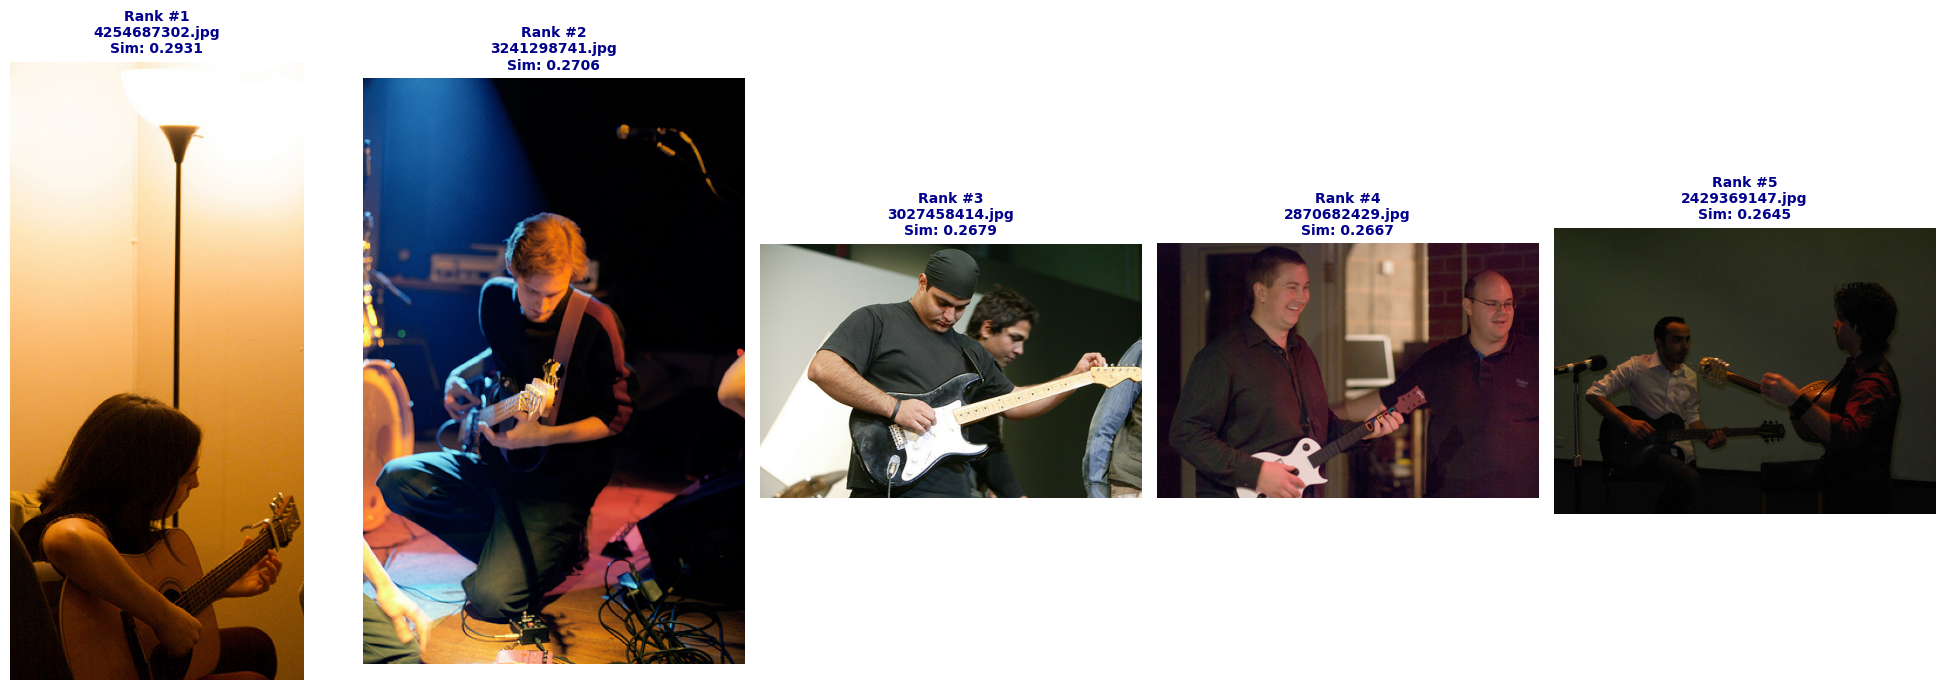


📊 DETAILED RETRIEVAL REPORT:


,Rank,Filename,Similarity Score,Ground Truth Caption (From Dataset)
0,1,4254687302.jpg,0.2931,"A woman plays guitar capoed up two frets , in..."
1,2,3241298741.jpg,0.2706,A musician wearing a black shirt is playing b...
2,3,3027458414.jpg,0.2679,A man dressed in black tunes a black electric...
3,4,2870682429.jpg,0.2667,A man in a brown shirt holding a guitar used ...
4,5,2429369147.jpg,0.2645,Musicians playing guitar in a church service ...


In [10]:
# @title Uji Coba & Tampilan Top-K (Detailed Report & Visualization)
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import os

# --- KONFIGURASI PENCARIAN ---
test_query = "Two men playing guitar"  # Ubah query di sini
K_VALUE = 5                            # Jumlah hasil

# 1. Helper Function: Mengambil Caption Asli dari Dataset (Untuk Detail)
def get_ground_truth(filename):
    try:
        # Membaca file captions jika belum ada di memori (atau gunakan df global)
        # Kita baca on-the-fly agar aman jika sel sebelumnya di-restart
        temp_df = pd.read_csv(Config.CAPTIONS_FILE, on_bad_lines='skip')
        temp_df.columns = [c.strip() for c in temp_df.columns]
        
        # Filter berdasarkan nama file
        subset = temp_df[temp_df['image'] == filename]['caption'].tolist()
        return subset[0] if subset else "[No Caption Found]"
    except Exception:
        return "[Metadata Error]"

print(f"🔎 PROCESSING QUERY: '{test_query}'")
print("-" * 80)

# 2. Eksekusi Retrieval (Vector Search)
query_vector = encoder.embed_text(test_query) 
retrieved_images, scores = vector_store.search(query_vector, k=K_VALUE)

# 3. Visualisasi Matplotlib (Grid View)
plt.figure(figsize=(20, 7)) # Canvas lebar

results_data = [] # Untuk menyimpan data tabel laporan

for rank, (img_filename, score) in enumerate(zip(retrieved_images, scores)):
    # A. Ambil Metadata (Detail)
    ground_truth_caption = get_ground_truth(img_filename)
    
    # B. Load Gambar
    try:
        img_path = os.path.join(Config.IMAGES_DIR, img_filename)
        image = Image.open(img_path).convert("RGB")
        
        # C. Plotting
        ax = plt.subplot(1, K_VALUE, rank + 1)
        plt.imshow(image)
        plt.axis("off")
        
        # Judul Gambar: Rank, Filename, Score
        title_text = f"Rank #{rank+1}\n{img_filename}\nSim: {score:.4f}"
        plt.title(title_text, fontsize=10, color='darkblue', fontweight='bold')
        
    except Exception as e:
        print(f"❌ Gagal render {img_filename}: {e}")

    # D. Simpan untuk Laporan Tabel
    results_data.append({
        "Rank": rank + 1,
        "Filename": img_filename,
        "Similarity Score": f"{score:.4f}",
        "Ground Truth Caption (From Dataset)": ground_truth_caption
    })

plt.tight_layout()
plt.show()

# 4. Laporan Detail (Tabular View)
print("\n📊 DETAILED RETRIEVAL REPORT:")
df_results = pd.DataFrame(results_data)
# Menampilkan tabel dataframe dengan styling sederhana (jika di Jupyter)
from IPython.display import display
display(df_results)

### **Evaluasi Kinerja Retrieval (Metrics)**

**Sesuai Penugasan Poin E:** *Matrix pengukuran performa (Recall@K)*.

**Deskripsi:**
Fungsi kualitatif untuk menguji performa sistem sebelum masuk ke tahap generatif. Ini membuktikan bahwa modul retrieval bekerja dengan benar.

--> Starting Evaluation on 100 random queries...


Evaluating: 100%|██████████| 100/100 [00:02<00:00, 37.08it/s]



📊 EVALUATION RESULTS (Recall@K):
----------------------------------------
   Recall@1: 26.00% (26/100 correct)
   Recall@5: 49.00% (49/100 correct)
   Recall@10: 57.00% (57/100 correct)
----------------------------------------


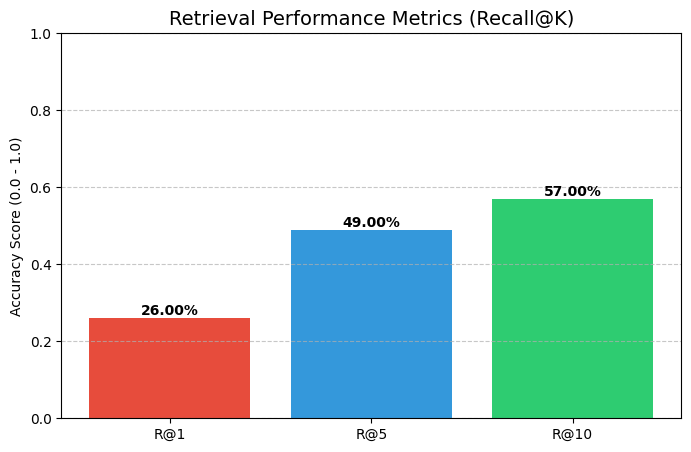

In [11]:
# @title Evaluasi Kuantitatif: Recall@K Metrics (Poin E)
import matplotlib.pyplot as plt
import seaborn as sns

class QuantitativeEvaluator:
    """
    Menghitung metrik standar industri untuk Image Retrieval: Recall@K.
    Mengukur seberapa sering gambar yang benar (Ground Truth) muncul dalam Top-K hasil pencarian.
    """
    def __init__(self, captions_file, vector_store, encoder):
        self.df = pd.read_csv(captions_file, on_bad_lines='skip')
        self.df.columns = [c.strip() for c in self.df.columns]
        self.vector_store = vector_store
        self.encoder = encoder
        
    def compute_metrics(self, sample_size=100, k_list=[1, 5, 10]):
        """
        Melakukan sampling random query dan mengecek posisi ranking gambar asli.
        """
        print(f"--> Starting Evaluation on {sample_size} random queries...")
        
        # 1. Sampling Data Uji
        # Kita ambil sampel acak dari caption yang ada
        test_sample = self.df.sample(n=sample_size, random_state=42)
        
        # Counter untuk setiap K
        hits = {k: 0 for k in k_list}
        max_k = max(k_list)
        
        # 2. Loop Evaluasi
        for _, row in tqdm(test_sample.iterrows(), total=sample_size, desc="Evaluating"):
            true_image = row['image']
            query_text = row['caption']
            
            # Embed Query
            q_vec = self.encoder.embed_text(query_text)
            
            # Search di Vector DB (Ambil sampai Max K)
            retrieved_imgs, _ = self.vector_store.search(q_vec, k=max_k)
            
            # Cek keberadaan Ground Truth di setiap level K
            for k in k_list:
                # Kita cek di irisan list sampai k
                if true_image in retrieved_imgs[:k]:
                    hits[k] += 1
                    
        # 3. Hitung Persentase (Recall Scores)
        results = {}
        print("\n📊 EVALUATION RESULTS (Recall@K):")
        print("-" * 40)
        for k in k_list:
            score = hits[k] / sample_size
            results[f"R@{k}"] = score
            print(f"   Recall@{k}: {score:.2%} ({hits[k]}/{sample_size} correct)")
        print("-" * 40)
            
        return results

    def visualize_results(self, metrics):
        """Membuat Plot Bar Chart untuk visualisasi performa."""
        plt.figure(figsize=(8, 5))
        keys = list(metrics.keys())
        vals = list(metrics.values())
        
        # Plotting
        bars = plt.bar(keys, vals, color=['#e74c3c', '#3498db', '#2ecc71'])
        
        # Styling
        plt.ylim(0, 1.0)
        plt.title(f"Retrieval Performance Metrics (Recall@K)", fontsize=14)
        plt.ylabel("Accuracy Score (0.0 - 1.0)")
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        
        # Menambah label angka di atas bar
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height,
                     f'{height:.2%}',
                     ha='center', va='bottom', fontweight='bold')
            
        plt.show()

# --- EKSEKUSI EVALUASI ---
# Note: sample_size=100 untuk demo cepat. 
# Untuk hasil Final Project yang robust, naikkan menjadi 500 atau 1000.
evaluator = QuantitativeEvaluator(Config.CAPTIONS_FILE, vector_store, encoder)
metrics_result = evaluator.compute_metrics(sample_size=100, k_list=[1, 5, 10])

# Tampilkan Grafik
evaluator.visualize_results(metrics_result)

### **Komponen 4: Generative Component (Visual Bridge & LLM)**

**Sesuai Penugasan Poin 4:** *BLIP-2 (Captioning) & Llama 3 (Reasoning)*.

**Deskripsi:**
Kelas `GenerativeEngine` mengelola dua model berat:

1.  **BLIP-2:** Berperan sebagai "mata", mengubah citra hasil retrieval menjadi deskripsi tekstual.
2.  **Llama-3 (via Ollama):** Berperan sebagai "otak", menerima konteks deskripsi dari BLIP-2 dan pertanyaan user untuk menghasilkan jawaban naratif.

In [2]:
# @title Komponen 4: Multimodal Generative Engine
import requests
from transformers import Blip2ForConditionalGeneration, Blip2Processor

class GenerativeEngine:
    def __init__(self, caption_model: str, llm_api: str, device: str):
        self.device = device
        self.llm_api = llm_api
        
        print(f"--> Loading BLIP-2 Model: {caption_model}...")
        # Load dengan presisi float16 untuk hemat VRAM
        dtype = torch.float16 if device == "cuda" else torch.float32
        self.blip_processor = Blip2Processor.from_pretrained(caption_model)
        self.blip_model = Blip2ForConditionalGeneration.from_pretrained(
            caption_model, torch_dtype=dtype
        ).to(device)
        
    def image_to_text(self, image_paths: List[str]) -> List[str]:
        """Menggunakan BLIP-2 untuk generate caption dari gambar."""
        captions = []
        for path in image_paths:
            full_path = os.path.join(Config.IMAGES_DIR, path)
            try:
                image = Image.open(full_path).convert('RGB')
                inputs = self.blip_processor(images=image, return_tensors="pt").to(self.device, torch.float16 if self.device=="cuda" else torch.float32)
                
                out_ids = self.blip_model.generate(**inputs, max_new_tokens=50)
                cap = self.blip_processor.batch_decode(out_ids, skip_special_tokens=True)[0].strip()
                captions.append(cap)
            except Exception as e:
                captions.append(f"[Error reading image: {str(e)}]")
        return captions

    def generate_answer(self, visual_contexts: List[str], user_query: str) -> str:
        """Mengirim prompt context-aware ke Llama 3 via Ollama."""
        context_block = "\n".join([f"- Visual Evidence {i+1}: {txt}" for i, txt in enumerate(visual_contexts)])
        
        prompt = f"""
        [INST]
        Anda adalah asisten AI yang mampu 'melihat'. Berikut adalah deskripsi dari gambar-gambar yang relevan dengan pertanyaan pengguna:
        
        {context_block}
        
        Pertanyaan Pengguna: "{user_query}"
        
        Berdasarkan bukti visual di atas, jawablah pertanyaan pengguna dalam Bahasa Indonesia yang natural, informatif, dan akurat. Jangan berhalusinasi jika informasi tidak ada di konteks.
        [/INST]
        """
        
        payload = {"model": Config.LLM_MODEL, "prompt": prompt, "stream": False}
        try:
            resp = requests.post(self.llm_api, json=payload)
            if resp.status_code == 200:
                return resp.json().get("response", "Error: Empty response")
            return f"LLM Error: {resp.status_code}"
        except Exception as e:
            return f"Ollama Connection Failed: {str(e)}"

# Inisialisasi (Heavy Load Warning)
gen_engine = GenerativeEngine(Config.CAPTION_MODEL, Config.LLM_API, Config.DEVICE)

--> Loading BLIP-2 Model: Salesforce/blip2-opt-2.7b...


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/10.0G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

In [4]:
# @title Vector Store & Run Demo
import faiss
import pandas as pd
import os
import numpy as np
from tqdm.auto import tqdm
from typing import List, Tuple

# 1. DEFINISI ULANG CLASS VECTOR STORE
class VectorStore:
    def __init__(self, dimension: int):
        self.index = faiss.IndexFlatIP(dimension)
        self.metadata: List[str] = []
        
    def build_from_dataset(self, df: pd.DataFrame, encoder, batch_size: int = 16):
        print("--> Building Index...")
        filenames = df['image_filename'].tolist()
        self.index.reset()
        self.metadata = []
        
        for i in tqdm(range(0, len(filenames), batch_size), desc="Indexing"):
            batch_files = filenames[i : i + batch_size]
            batch_paths = [os.path.join(Config.IMAGES_DIR, f) for f in batch_files]
            emb = encoder.embed_images(batch_paths)
            if len(emb) > 0:
                self.index.add(emb.astype('float32'))
                self.metadata.extend(batch_files)
        self.save()
        print(f"✅ Index Built: {self.index.ntotal} vectors.")

    def search(self, query_vector: np.ndarray, k: int = 5) -> Tuple[List[str], List[float]]:
        distances, indices = self.index.search(query_vector.astype('float32'), k)
        results = []
        scores = []
        for idx, dist in zip(indices[0], distances[0]):
            if idx != -1:
                results.append(self.metadata[idx])
                scores.append(float(dist))
        return results, scores

    def save(self):
        faiss.write_index(self.index, Config.INDEX_PATH)
        with open(Config.METADATA_PATH, 'w') as f:
            json.dump(self.metadata, f)
            
    def load(self):
        self.index = faiss.read_index(Config.INDEX_PATH)
        with open(Config.METADATA_PATH, 'r') as f:
            self.metadata = json.load(f)

# 2. INISIALISASI OTOMATIS
print("⚙️ Checking Encoder Dimensions...")
dummy_vec = encoder.embed_text("test")
REAL_DIM = dummy_vec.shape[1]
print(f"   Dimension detected: {REAL_DIM}")

vector_store = VectorStore(dimension=REAL_DIM)

# Cek apakah index sudah ada di disk?
if os.path.exists(Config.INDEX_PATH) and os.path.exists(Config.METADATA_PATH):
    print(f"📂 Loading existing index from {Config.INDEX_PATH}...")
    try:
        vector_store.load()
        # Validasi dimensi index yang di-load
        if vector_store.index.d != REAL_DIM:
            print("⚠️ Dimension Mismatch in loaded file. Rebuilding...")
            raise ValueError("Dimensi salah")
    except:
        # Jika gagal load, build ulang
        if 'df_images' not in locals():
            df_images = pd.read_csv(Config.CAPTIONS_FILE, on_bad_lines='skip')
            df_images.columns = [c.strip() for c in df_images.columns]
            df_images = pd.DataFrame(df_images['image'].unique(), columns=['image_filename'])
        vector_store.build_from_dataset(df_images, encoder, Config.BATCH_SIZE)
else:
    print("🔨 Index not found. Building new index...")
    if 'df_images' not in locals():
        df_images = pd.read_csv(Config.CAPTIONS_FILE, on_bad_lines='skip')
        df_images.columns = [c.strip() for c in df_images.columns]
        df_images = pd.DataFrame(df_images['image'].unique(), columns=['image_filename'])
    vector_store.build_from_dataset(df_images, encoder, Config.BATCH_SIZE)

# 3. JALANKAN RAG DEMO
def run_full_rag(user_query: str):
    print(f"\n🎯 PROCESSING QUERY: '{user_query}'")
    print("-" * 50)
    
    # Retrieval
    print("🔍 1. Searching Vector Database...")
    q_vec = encoder.embed_text(user_query)
    retrieved_files, scores = vector_store.search(q_vec, k=3)
    
    if not retrieved_files:
        print("❌ No images found.")
        return

    print(f"   --> Found {len(retrieved_files)} images.")
    
    # Visual Understanding
    print("👁️ 2. Analyzing Images (BLIP-2)...")
    visual_contexts = gen_engine.image_to_text(retrieved_files)
    
    for i, (img, ctx) in enumerate(zip(retrieved_files, visual_contexts)):
        print(f"   [Image {i+1}]: {ctx}")

    # Reasoning
    print("🧠 3. Generating Answer (Llama 3)...")
    final_answer = gen_engine.generate_answer(visual_contexts, user_query)
    
    print("\n" + "="*50)
    print("🤖 FINAL AI RESPONSE:")
    print("="*50)
    print(final_answer)
    print("="*50)

# --- TEST RUN ---
run_full_rag("Two men playing guitar in the garden")

⚙️ Checking Encoder Dimensions...
   Dimension detected: 768
📂 Loading existing index from flickr30k_large.index...
--> Building Index...


Indexing:   0%|          | 0/1987 [00:00<?, ?it/s]

KeyboardInterrupt: 

### **Komponen 5: User Interface (Streamlit Auto-Generator)**

**Sesuai Penugasan Poin 5:** *Web UI sederhana menggunakan Streamlit*.

**Lokasi Path :** User_Interface/app.py